In [345]:
from datetime import datetime
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import nltk

nltk.download("vader_lexicon")
nltk.download("punkt")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/nolok/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/nolok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [346]:
DATE_FORMATS = (
    "%B %d, %Y ",
    "%B %d, %Y",
    "%d-%B-%y",
    "%b %d, %Y ",
    "%b %d, %Y",
    "%d-%b-%y"
)

BAD_SYMBOLS = (
    '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
    ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|',
    '}', '~'
)

stop_words = set(stopwords.words("english"))
sid = SentimentIntensityAnalyzer()


def plot_records_months(monthly_counts) -> None:
    plt.figure(figsize=(10, 6))

    plt.plot(
        monthly_counts.index,
        monthly_counts["date"],
        marker="o",
        linestyle="-",
        color="b"
        )

    plt.title("Liczba rekordów per miesiąc")
    plt.xlabel("Data")
    plt.ylabel("Liczba rekordów")

    plt.grid(True)
    plt.show()


def plot_subejcts_months(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))

    subjects = df["subject"].unique()

    for subject in subjects:
        monthly_counts = df[df["subject"] == subject].resample("M").count()
        plt.plot(
            monthly_counts.index,
            monthly_counts["date"],
            marker="o",
            linestyle="-",
            label=subject
            )

    plt.xlabel("Data")
    plt.ylabel("Liczba wystąpień")
    plt.title("Liczba wystąpień 'subject' w czasie")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


def plot_bar_for_sentiment(df: pd.DataFrame, second_dimension: str) -> None:
    grouped_data = df \
        .groupby(second_dimension)["sentiment"] \
        .value_counts() \
        .unstack() \
        .fillna(0)

    _, ax = plt.subplots(figsize=(10, 6))

    grouped_data.plot(kind="bar", stacked=False, ax=ax)
    plt.xlabel(second_dimension.title())
    plt.ylabel("Liczność Sentimentu")
    plt.title(f"Wykres grupowy dla {second_dimension} i Sentiment")
    plt.legend(title="Sentiment", loc="upper left")

    for p in ax.patches:
        ax.annotate(
            str(int(p.get_height())),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points"
            )

    plt.show()


def to_datetime(date_str: str) -> datetime:
    result = None

    for format in DATE_FORMATS:
        try:
            result = pd.to_datetime(date_str, format=format)
        except ValueError:
            pass

        if result is not None:
            break

    return result


def check_sentiment(text: str) -> str:
    scores = sid.polarity_scores(text)
    sentiment = max(scores, key=scores.get)
    return sentiment


def remove_stop_words(text: str) -> str:
    words = word_tokenize(text, "english")
    filtered_words = [
        word.lower()
        for word in words
        if word.lower() not in stop_words
        ]

    return ' '.join(filtered_words)


# Real news - Analysing data

In [347]:
df_real = pd.read_csv("../data/raw/True.csv")
df_real["label"] = "real"
df_real.dtypes


title      object
text       object
subject    object
date       object
label      object
dtype: object

In [348]:
df_real.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  object
dtypes: object(5)
memory usage: 836.7+ KB


In [349]:
df_real.isna().sum()


title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [350]:
df_real.describe()


,title,text,subject,date,label
count,21417,21417,21417,21417,21417
unique,20826,21192,2,716,1
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017",real
freq,14,8,11272,182,21417


In [351]:
df_real["subject"].value_counts()


subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

In [352]:
df_real["date_index"] = df_real["date"] = df_real["date"].apply(to_datetime)
df_real.set_index("date_index", inplace=True)
df_real


,title,text,subject,date,label
date_index,,,,,
2017-12-31,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,real
2017-12-29,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,real
2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,real
2017-12-30,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,real
2017-12-29,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,real
...,...,...,...,...,...
2017-08-22,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22,real
2017-08-22,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,real
2017-08-22,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,real


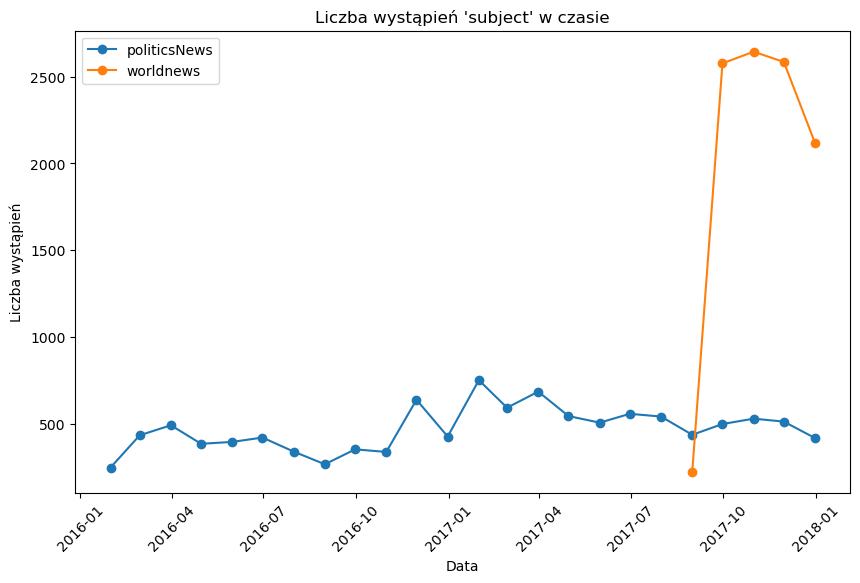

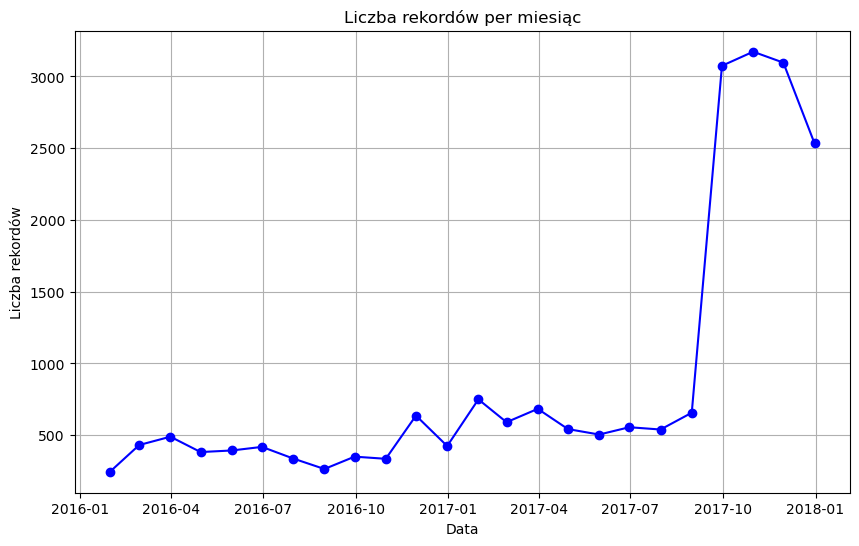

In [353]:
plot_subejcts_months(df_real)

real_monthly_counts = df_real.resample("M").count()
plot_records_months(real_monthly_counts)


In [354]:
print(df_real.shape)
df_real = df_real.drop_duplicates(subset=["text"], ignore_index=True)
print(df_real.shape)


(21417, 5)
(21192, 5)


In [355]:
df_real["all_text"] = df_real["title"] + " " + df_real["text"]
del df_real["title"]
del df_real["text"]
df_real


/tmp/ipykernel_5279/1977164670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real["all_text"] = df_real["title"] + " " + df_real["text"]


,subject,date,label,all_text
0,politicsNews,2017-12-31,real,"As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,2017-12-29,real,U.S. military to accept transgender recruits o...
2,politicsNews,2017-12-31,real,Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,2017-12-30,real,FBI Russia probe helped by Australian diplomat...
4,politicsNews,2017-12-29,real,Trump wants Postal Service to charge 'much mor...
...,...,...,...,...
21187,worldnews,2017-08-22,real,'Fully committed' NATO backs new U.S. approach...
21188,worldnews,2017-08-22,real,LexisNexis withdrew two products from Chinese ...
21189,worldnews,2017-08-22,real,Minsk cultural hub becomes haven from authorit...
21190,worldnews,2017-08-22,real,Vatican upbeat on possibility of Pope Francis ...


In [356]:
df_real["all_text"][0]


'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

# Fake news - Analysing data

In [357]:
df_fake = pd.read_csv("../data/raw/Fake.csv")
df_fake["label"] = "fake"
df_fake.dtypes


title      object
text       object
subject    object
date       object
label      object
dtype: object

In [358]:
df_fake["date_index"] = df_fake["date"] = df_fake["date"].apply(to_datetime)
df_fake.set_index("date_index", inplace=True)
df_fake


,title,text,subject,date,label
date_index,,,,,
2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake
2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake
2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake
2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake
2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake
...,...,...,...,...,...
2016-01-16,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,fake
2016-01-16,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,fake
2016-01-15,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,fake


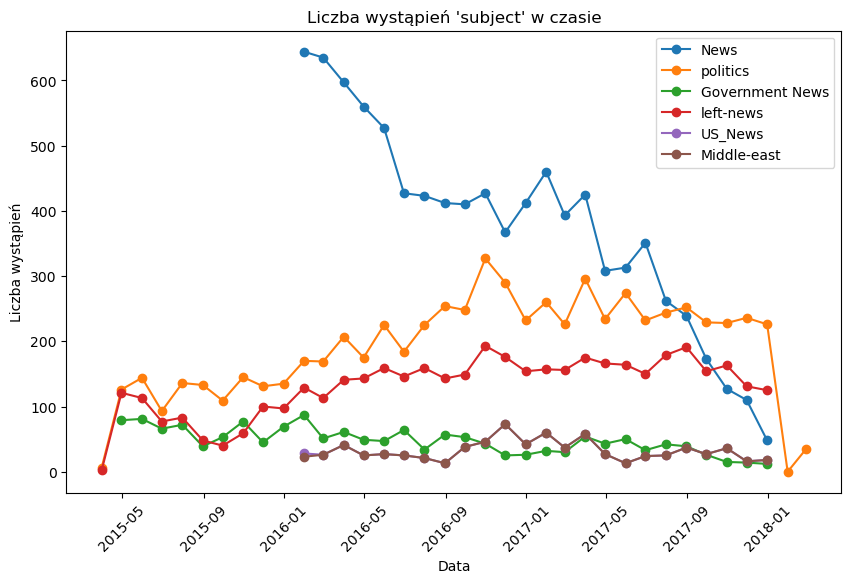

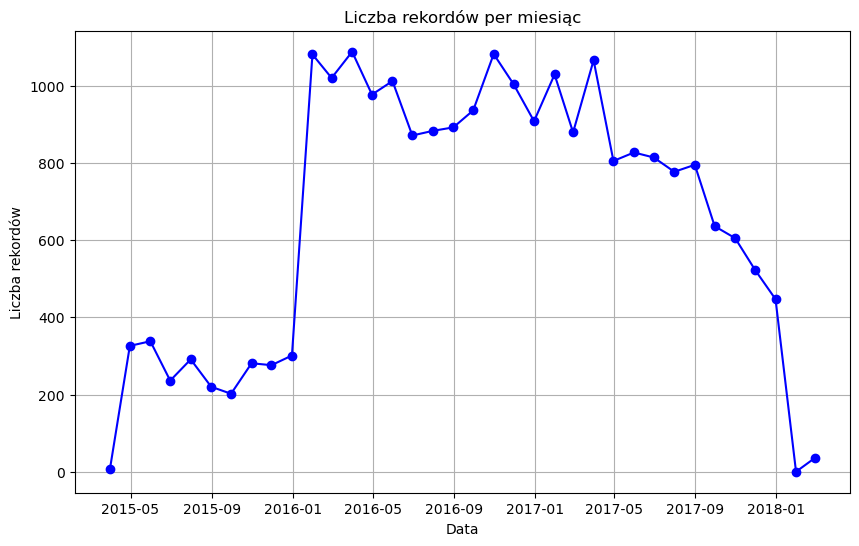

In [359]:
plot_subejcts_months(df_fake)

fake_monthly_counts = df_fake.resample("M").count()
plot_records_months(fake_monthly_counts)


In [360]:
print(df_fake.shape)
df_fake = df_fake.drop_duplicates(subset=["text"], ignore_index=True)
print(df_fake.shape)


(23481, 5)
(17455, 5)


In [361]:
df_fake.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17455 entries, 0 to 17454
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    17455 non-null  object        
 1   text     17455 non-null  object        
 2   subject  17455 non-null  object        
 3   date     17449 non-null  datetime64[ns]
 4   label    17455 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 682.0+ KB


In [362]:
df_fake.isna().sum()


title      0
text       0
subject    0
date       6
label      0
dtype: int64

In [363]:
df_fake.describe()


,date
count,17449
mean,2016-10-04 17:22:38.175253248
min,2015-03-31 00:00:00
25%,2016-04-04 00:00:00
50%,2016-10-01 00:00:00
75%,2017-04-08 00:00:00
max,2018-02-19 00:00:00


In [364]:
df_fake["subject"].value_counts()


subject
News               9050
politics           6425
US_News             783
left-news           683
Government News     514
Name: count, dtype: int64

In [365]:
df_fake["all_text"] = df_fake["title"] + " " + df_fake["text"]
del df_fake["title"]
del df_fake["text"]
df_fake


/tmp/ipykernel_5279/810944748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake["all_text"] = df_fake["title"] + " " + df_fake["text"]


,subject,date,label,all_text
0,News,2017-12-31,fake,Donald Trump Sends Out Embarrassing New Year’...
1,News,2017-12-31,fake,Drunk Bragging Trump Staffer Started Russian ...
2,News,2017-12-30,fake,Sheriff David Clarke Becomes An Internet Joke...
3,News,2017-12-29,fake,Trump Is So Obsessed He Even Has Obama’s Name...
4,News,2017-12-25,fake,Pope Francis Just Called Out Donald Trump Dur...
...,...,...,...,...
17450,US_News,2016-01-07,fake,The White House and The Theatrics of ‘Gun Cont...
17451,US_News,2016-01-07,fake,Activists or Terrorists? How Media Controls an...
17452,US_News,2016-01-06,fake,"BOILER ROOM – No Surrender, No Retreat, Heads ..."
17453,US_News,2016-01-04,fake,Federal Showdown Looms in Oregon After BLM Abu...


# Concatenating data


In [366]:
df = pd.concat([df_real, df_fake])
df.reset_index(drop=True, inplace=True)

print(df.shape)

df.head()


(38647, 4)


,subject,date,label,all_text
0,politicsNews,2017-12-31,real,"As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,2017-12-29,real,U.S. military to accept transgender recruits o...
2,politicsNews,2017-12-31,real,Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,2017-12-30,real,FBI Russia probe helped by Australian diplomat...
4,politicsNews,2017-12-29,real,Trump wants Postal Service to charge 'much mor...


/home/nolok/anaconda3/envs/zprp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nolok/anaconda3/envs/zprp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nolok/anaconda3/envs/zprp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Etykieta', ylabel='Średnia długość'>

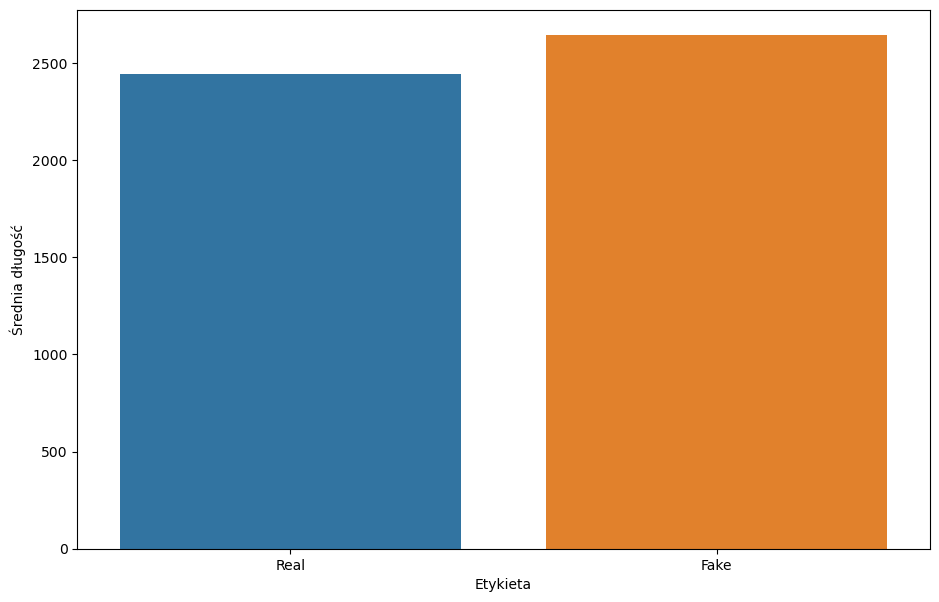

In [367]:
avg_len_real = df[df["label"] == "real"]["all_text"].apply(
    lambda x: len(x)
    ).mean()

avg_len_fake = df[df["label"] == "fake"]["all_text"].apply(
    lambda x: len(x)
    ).mean()

avg_len = pd.DataFrame(
    data = {"Średnia długość": [avg_len_real, avg_len_fake],
            "Etykieta": ["Real", "Fake"]}
            )

fig, bar = plt.subplots(figsize = (11, 7))
sns.barplot(y="Średnia długość", x="Etykieta", data=avg_len)


In [368]:
def lower_text(text: str) -> str:
    return text.lower()


def remove_html(text: str):
    return re.sub("()", "", text, flags=re.DOTALL)


def remove_url(text: str) -> str:
    return re.sub(r'https?:\/\/.\S+', "", text)


def remove_brackets(text: str) -> str:
    text = re.sub("\\[]", "", text)
    text = re.sub("\\(\\)", "", text)
    text = re.sub("\\{}", "", text)
    text = re.sub("\\]", "", text)
    text = re.sub("\\[", "", text)
    return text


def remove_bad_symbols(text: str) -> str:
    for bad_symbol in BAD_SYMBOLS:
        text = text.replace(bad_symbol, "")
    return text


def clear_text(text: str) -> str:
    text = lower_text(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_brackets(text)
    text = remove_bad_symbols(text)
    return text


In [369]:
df["clear_text"] = df["all_text"].apply(clear_text)
del df["all_text"]
df


,subject,date,label,clear_text
0,politicsNews,2017-12-31,real,as us budget fight looms republicans flip thei...
1,politicsNews,2017-12-29,real,us military to accept transgender recruits on ...
2,politicsNews,2017-12-31,real,senior us republican senator let mr mueller do...
3,politicsNews,2017-12-30,real,fbi russia probe helped by australian diplomat...
4,politicsNews,2017-12-29,real,trump wants postal service to charge much more...
...,...,...,...,...
38642,US_News,2016-01-07,fake,the white house and the theatrics of ‘gun cont...
38643,US_News,2016-01-07,fake,activists or terrorists how media controls and...
38644,US_News,2016-01-06,fake,boiler room – no surrender no retreat heads wi...
38645,US_News,2016-01-04,fake,federal showdown looms in oregon after blm abu...


In [370]:
df["clear_text"] = df["clear_text"].apply(remove_stop_words)
df


,subject,date,label,clear_text
0,politicsNews,2017-12-31,real,us budget fight looms republicans flip fiscal ...
1,politicsNews,2017-12-29,real,us military accept transgender recruits monday...
2,politicsNews,2017-12-31,real,senior us republican senator let mr mueller jo...
3,politicsNews,2017-12-30,real,fbi russia probe helped australian diplomat ti...
4,politicsNews,2017-12-29,real,trump wants postal service charge much amazon ...
...,...,...,...,...
38642,US_News,2016-01-07,fake,white house theatrics ‘ gun control ’ 21st cen...
38643,US_News,2016-01-07,fake,activists terrorists media controls dictates ‘...
38644,US_News,2016-01-06,fake,boiler room – surrender retreat heads roll – e...
38645,US_News,2016-01-04,fake,federal showdown looms oregon blm abuse local ...


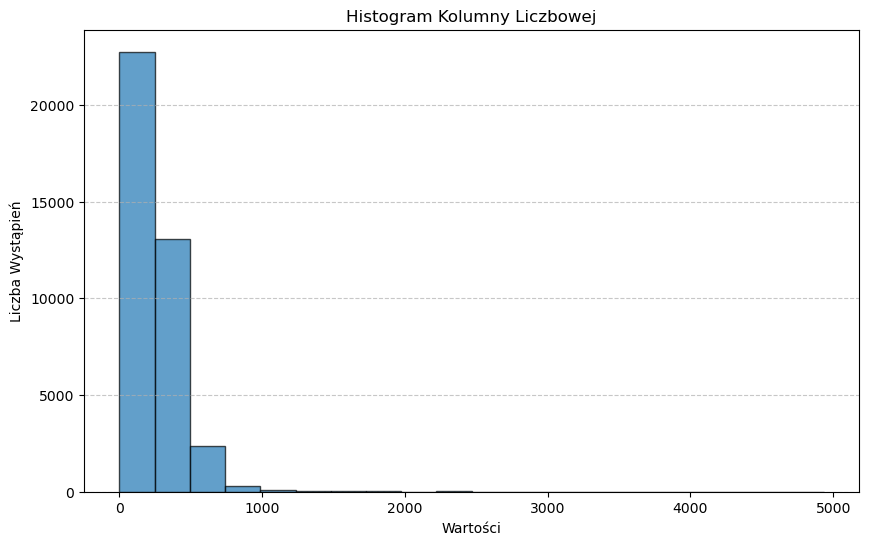

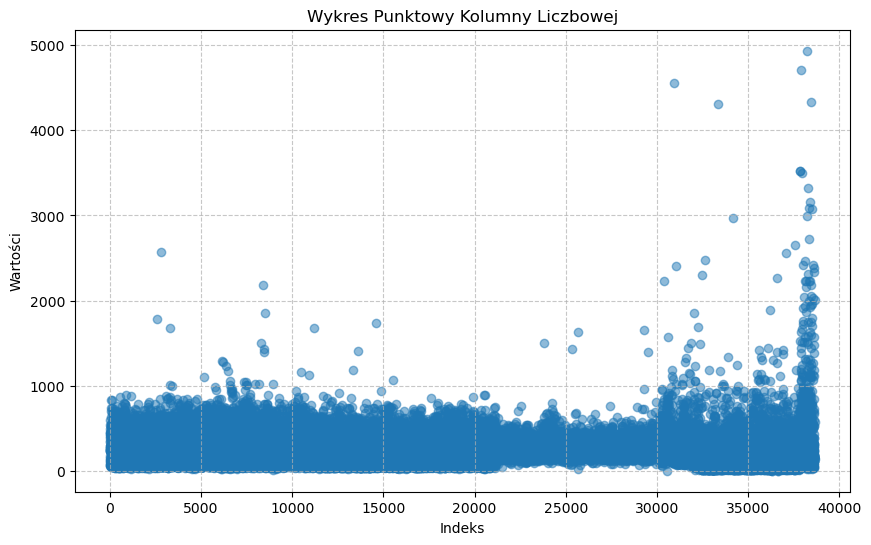

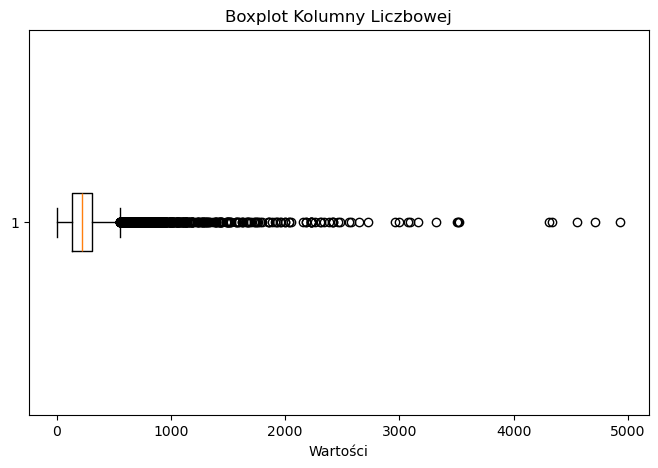

In [371]:
def split_len(text: str) -> int:
    return len(text.split(" "))


df["words_counter"] = df["clear_text"].apply(split_len)
df["words_counter"].value_counts()



plt.figure(figsize=(10, 6))
plt.hist(df['words_counter'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Wartości')
plt.ylabel('Liczba Wystąpień')
plt.title('Histogram Kolumny Liczbowej')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['words_counter'], alpha=0.5)
plt.xlabel('Indeks')
plt.ylabel('Wartości')
plt.title('Wykres Punktowy Kolumny Liczbowej')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(df['words_counter'], vert=False)
plt.xlabel('Wartości')
plt.title('Boxplot Kolumny Liczbowej')
plt.show()

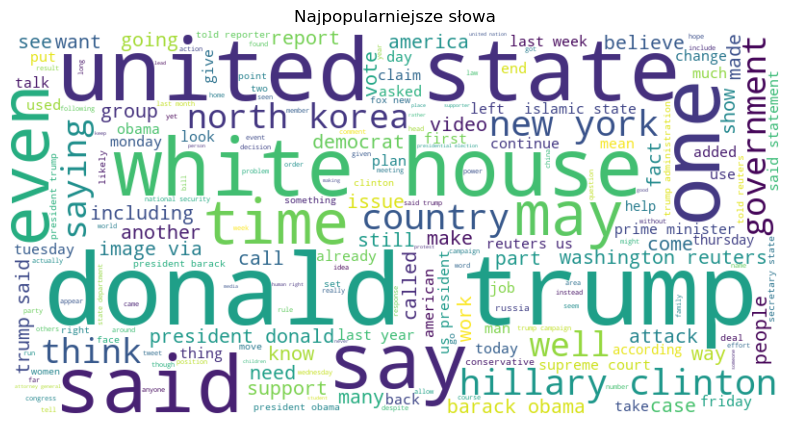

In [372]:
all_text = ' '.join(df["clear_text"].astype(str))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
    ).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Najpopularniejsze słowa")
plt.show()


/home/nolok/anaconda3/envs/zprp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nolok/anaconda3/envs/zprp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nolok/anaconda3/envs/zprp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Etykieta', ylabel='Liczba rekordów'>

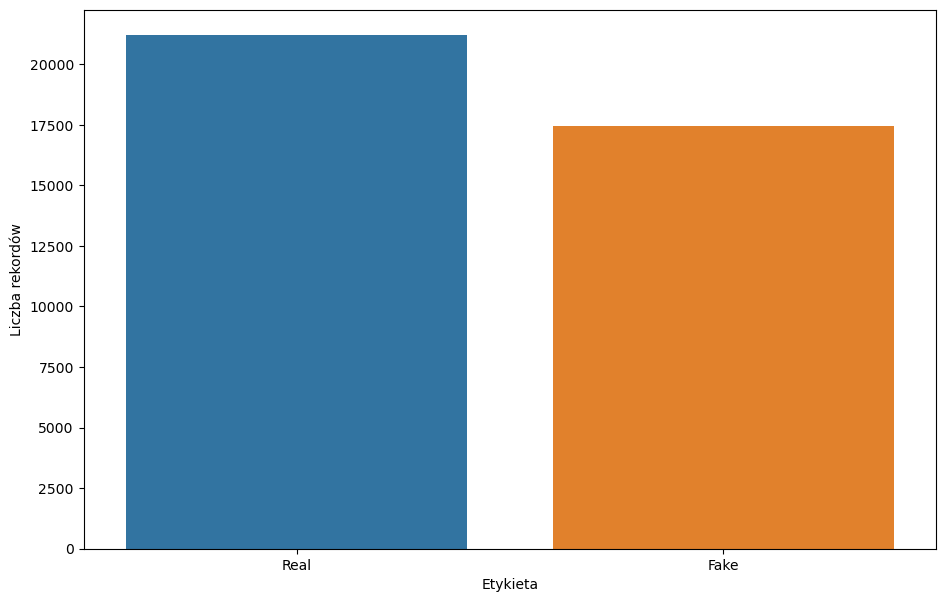

In [373]:
count_real = df[df["label"] == "real"].shape[0]
count_fake = df[df["label"] == "fake"].shape[0]

avg_len = pd.DataFrame(
    data = {"Liczba rekordów": [count_real, count_fake],
            "Etykieta": ["Real", "Fake"]}
            )

fig, bar = plt.subplots(figsize = (11, 7))
sns.barplot(y="Liczba rekordów", x="Etykieta", data=avg_len)


In [374]:
samples_count = count_real - count_fake
fake_samples_sampled = df[df["label"] == "fake"].sample(n=samples_count, random_state=42, replace=True)
df = pd.concat([df, fake_samples_sampled])


/home/nolok/anaconda3/envs/zprp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nolok/anaconda3/envs/zprp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nolok/anaconda3/envs/zprp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Etykieta', ylabel='Liczba rekordów'>

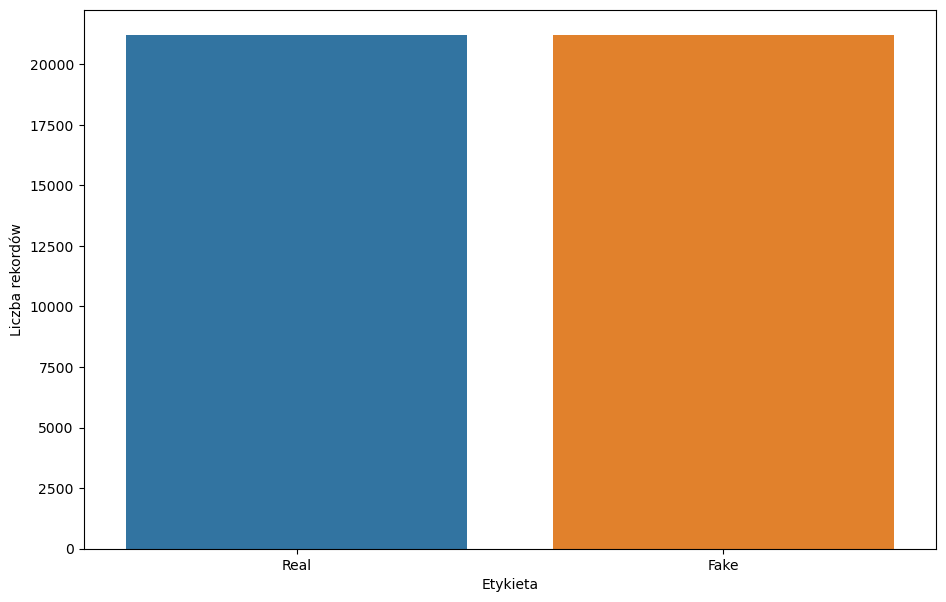

In [375]:
count_real = df[df["label"] == "real"].shape[0]
count_fake = df[df["label"] == "fake"].shape[0]

avg_len = pd.DataFrame(
    data = {"Liczba rekordów": [count_real, count_fake],
            "Etykieta": ["Real", "Fake"]}
            )

fig, bar = plt.subplots(figsize = (11, 7))
sns.barplot(y="Liczba rekordów", x="Etykieta", data=avg_len)


In [376]:
df["sentiment"] = df["clear_text"].apply(check_sentiment)
df


,subject,date,label,clear_text,words_counter,sentiment
0,politicsNews,2017-12-31,real,us budget fight looms republicans flip fiscal ...,493,compound
1,politicsNews,2017-12-29,real,us military accept transgender recruits monday...,412,compound
2,politicsNews,2017-12-31,real,senior us republican senator let mr mueller jo...,289,neu
3,politicsNews,2017-12-30,real,fbi russia probe helped australian diplomat ti...,250,neu
4,politicsNews,2017-12-29,real,trump wants postal service charge much amazon ...,536,compound
...,...,...,...,...,...,...
36927,Government News,2016-01-05,fake,want know meat comes days one word china reaso...,535,neu
37022,Government News,2015-09-26,fake,breaking report german reporter embedded isis ...,214,neu
36317,politics,2015-07-03,fake,hillary ’ turn lib publications saying hillary...,491,compound
33097,politics,2016-12-21,fake,diamond silk go michelle obama saying lost hop...,28,compound


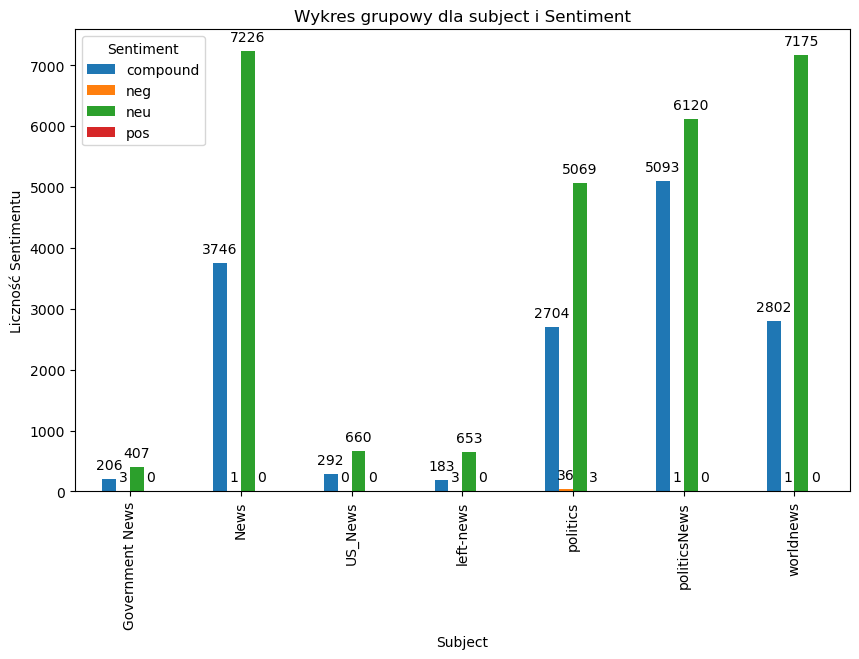

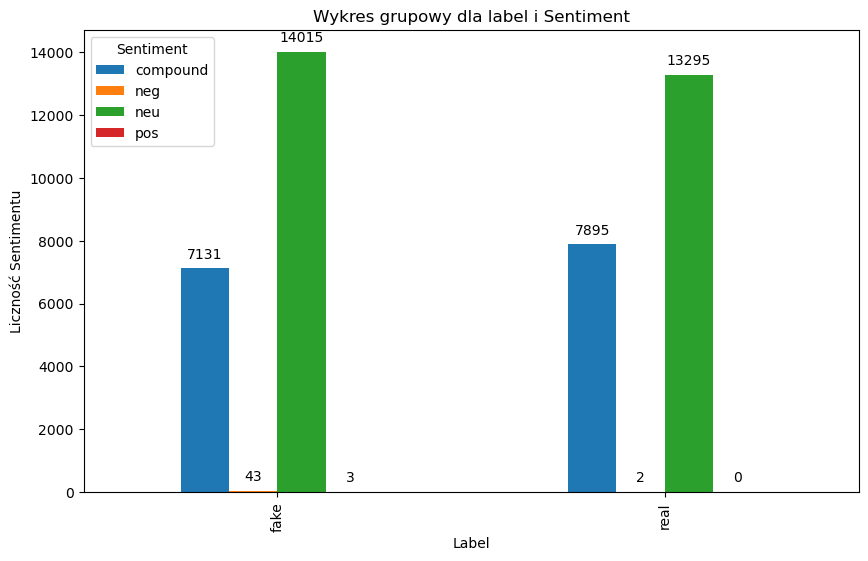

In [377]:
plot_bar_for_sentiment(df, "subject")
plot_bar_for_sentiment(df, "label")


In [378]:
df.shape

(42384, 6)

In [379]:
df.to_csv("../data/processed/Data.csv")
